# Loading the required Dataset

In [628]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math

# Loading Iris Dataset Without using it's labels


In [629]:
from sklearn.datasets import load_iris

iris = load_iris()
x_train = iris.data


In [630]:
x_train.shape

(150, 4)

# Defining the PCA algorithm's Functions

In [631]:
# Function that Calculate the covariance between two variables
def covariance(x, y):
    n = len(x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    mat = (x - mean_x) * (y - mean_y)
    return np.mean(mat)

# Function that Calculate the covariance matrix for a dataset
def covariance_matrix(data):
    n_variables = len(data[0])
    n_observations = len(data)
    
    # Initialize the covariance matrix with zeros
    cov_matrix = np.zeros([n_variables,n_variables])
    # Calculate the covariance for each pair of variables
    for i in range(n_variables):
        for j in range(n_variables):
            if i == j:
                cov_matrix[i][j] = covariance(data[:,i],data[:,i])
            else:
                cov_matrix[i][j] = covariance(data[:,i], data[:,j])

    return cov_matrix


In [632]:
import numpy as np

# Function that finds eigenvalues of a 4x4 matrix 
def find_eigenvalues_4x4(matrix):
    # This function returns approximate eigenvalues for the matrix
    a = -1
    b = np.trace(matrix)
    c = (np.linalg.det(matrix[:2, :2]) + np.linalg.det(matrix[2:, 2:]) + 
         np.linalg.det(matrix[:2, 2:]) + np.linalg.det(matrix[2:, :2]))
    d = (-np.linalg.det(matrix[:3, :3]) - np.linalg.det(matrix[1:, 1:]) - 
         np.linalg.det(np.vstack([matrix[:2, :2], matrix[3, :2]])) - 
         np.linalg.det(np.vstack([matrix[:2, 2:], matrix[3, 2:]])))
    e = np.linalg.det(matrix)
    coefficients = [a, b, c, d, e]
    eigenvalues = np.roots(coefficients)
    return eigenvalues

# Function to find eigenvectors for each eigenvalue
def find_eigenvectors_4x4(matrix, eigenvalues):
    eigenvectors = []
    for lamb in eigenvalues:
        eig_matrix = matrix - lamb * np.identity(4)
        _, _, vh = np.linalg.svd(eig_matrix)
        eigenvector = vh[-1]  
        eigenvectors.append(eigenvector)
    return eigenvectors





# Defining The PCA 

In [633]:
# Class For PCA to store the Q matrix and the data mean
class pca:
    def __init__(self ,N=2):
        self.N = N
    def compute_pca(self,X, n_components=2):
        
        # mean center the data
        self.mean = np.mean(X, axis=0)
        X_demeaned = X - self.mean

        # calculate the covariance matrix
        covariance_matrixx = covariance_matrix(X_demeaned)

        # calculate eigenvectors & eigenvalues of the covariance matrix
        eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrixx)
        
        eigen_vecs_norm =  np.linalg.norm(eigen_vecs,axis = 1)
        eigen_vecs = np.divide(eigen_vecs.T , eigen_vecs_norm).T
        # sort eigenvalue in increasing order (get the indices from the sort)
        idx_sorted = np.argsort(eigen_vals)

        # reverse the order so that it's from highest to lowest.
        idx_sorted_decreasing = idx_sorted[::-1]

        # sort the eigen values by idx_sorted_decreasing
        eigen_vals_sorted = eigen_vals[idx_sorted_decreasing]

        # sort eigenvectors using the idx_sorted_decreasing indices
        eigen_vecs_sorted = eigen_vecs[:,idx_sorted_decreasing]
        
        

        # select the first n eigenvectors (n is desired dimension
        # of rescaled data array, or n_components)
        eigen_vecs_subset = eigen_vecs_sorted[:,:n_components]

        # transform the data by multiplying the transpose of the eigenvectors with the transpose of the de-meaned data
        # Then take the transpose of that product.
        X_reduced = np.dot(eigen_vecs_subset.T , X_demeaned.T).T
        self.eigen = eigen_vecs_subset

        return X_reduced
    
    def reconstruct_from_pca(self,X_reduced):
        # Multiply reduced data with eigenvectors to get approximation of original data
        X_approx = np.dot(X_reduced, self.eigen.T)

        # Add back the mean to get the original scale
        X_approx = X_approx + self.mean

        return X_approx


# Testing all possible Q matrices where the range is (1,N-1) N is the no. of Features 


In [634]:
from tqdm import tqdm

N = 150 # no. of samples 
pcas = [] # list of pca object for each Q matrix 
var = {} # Dic for storing the variances of each reduced data
p_col =[] # list to store the reduced data for each Different Q matrix
for i in tqdm(range(1,4)): 
    pcas.append(pca(N=N))
    p_col.append(pcas[i-1].compute_pca(x_train,i))
    var[i] = np.mean(np.var(p_col[i-1] ,axis = 0))
    

100%|██████████| 3/3 [00:00<00:00, 803.61it/s]


# Computing the variance of each reduced data and plotting it

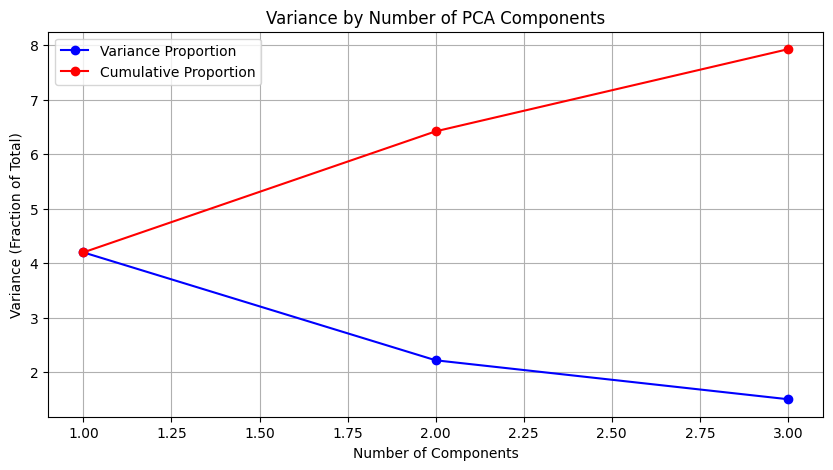

In [635]:

# Extract variances and sort by number of components
components, variance = zip(*sorted(var.items()))

# Calculate cumulative variance 
cumulative_variance = np.cumsum(variance)

total_variance = cumulative_variance[-1]
cumulative_proportion_variance = cumulative_variance 

proportion_variance = np.array(variance) 

# Plotting both variance proportion and cumulative proportion
plt.figure(figsize=(10, 5))
plt.plot(components, proportion_variance, marker='o', color='blue', label='Variance Proportion')
plt.plot(components, cumulative_proportion_variance, marker='o', color='red', label='Cumulative Proportion')
plt.xlabel('Number of Components')
plt.ylabel('Variance (Fraction of Total)')
plt.title('Variance by Number of PCA Components')
plt.legend()
plt.grid(True)
plt.show()


# The same reconstructed sample from each different Q matrix compared to the Original

In [636]:
rescaled_col =[]
for i in range(3):
    rescaled_col.append(pcas[i].reconstruct_from_pca(p_col[i]))
    

In [637]:
# The reconstructed data where N = 1
rescaled_col[0][0]

array([4.87332632, 3.28420238, 1.45858847, 0.23764012])

In [638]:
# The reconstructed data where N = 2
rescaled_col[1][0]

array([5.08303897, 3.51741393, 1.40321372, 0.21353169])

In [639]:
# The reconstructed data where N = 3
rescaled_col[2][0]

array([5.09928623, 3.50072335, 1.40108561, 0.1982949 ])

In [640]:
# Original sample
x_train[0]

array([5.1, 3.5, 1.4, 0.2])

# Visulizing mean squared error between each sample and the original 

In [641]:
from sklearn.metrics import mean_squared_error
mse = []
for i in range(3):
    mse.append(mean_squared_error(x_train,rescaled_col[i]))

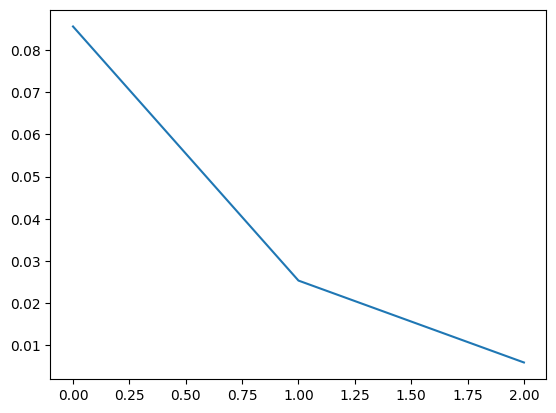

In [642]:
plt.plot(mse)

## After using 3 different Q matrices (we have 4 features) no. of components range is 1,n-1 for features
## we concluded after using mse error from the above figure that the best choice is N=2 as it gave a very good mse loss while reducing the dimentionality by 0.5 
## N=2 got better loss than N=1 and less dimension that N=3

In [643]:
p_col[1]

array([[ 2.68412563,  0.31939725],
       [ 2.71414169, -0.17700123],
       [ 2.88899057, -0.14494943],
       [ 2.74534286, -0.31829898],
       [ 2.72871654,  0.32675451],
       [ 2.28085963,  0.74133045],
       [ 2.82053775, -0.08946138],
       [ 2.62614497,  0.16338496],
       [ 2.88638273, -0.57831175],
       [ 2.6727558 , -0.11377425],
       [ 2.50694709,  0.6450689 ],
       [ 2.61275523,  0.01472994],
       [ 2.78610927, -0.235112  ],
       [ 3.22380374, -0.51139459],
       [ 2.64475039,  1.17876464],
       [ 2.38603903,  1.33806233],
       [ 2.62352788,  0.81067951],
       [ 2.64829671,  0.31184914],
       [ 2.19982032,  0.87283904],
       [ 2.5879864 ,  0.51356031],
       [ 2.31025622,  0.39134594],
       [ 2.54370523,  0.43299606],
       [ 3.21593942,  0.13346807],
       [ 2.30273318,  0.09870885],
       [ 2.35575405, -0.03728186],
       [ 2.50666891, -0.14601688],
       [ 2.46882007,  0.13095149],
       [ 2.56231991,  0.36771886],
       [ 2.63953472,

# Defining the Entropy based Fuzzy Functions

In [644]:
epsilon=1e-10
# Function to calculate the euclidan distances
def Distance_matrix(x_train):
    dist = np.zeros((x_train.shape[0], x_train.shape[0]))
    for i in range(x_train.shape[0]):
        for j in range(x_train.shape[0]):
            dist[i, j] = np.linalg.norm(x_train[i] - x_train[j])
    return dist

# Function to calculate the mean of all euclidan distances 
def Distance_Mean(dist):
    sums = 0
    count = 0
    for i in range(1,dist.shape[0]):
        for j in range(i):
            sums += dist[i,j]
            count += 1
    return sums/count

# Function to calculate the alpha varible 
def Alpha(dist_mean,beta=0.5):
    if(beta<1):
        alpha = np.log(1/beta) / dist_mean
    else :
        alpha =  -np.log(beta) / dist_mean
    return alpha

# Function to calculate the Similarity between points 
def Similarity(alpha,dist):
    S = np.zeros((dist.shape[0],dist.shape[0]))
    for i in range(dist.shape[0]):
        for j in range(dist.shape[0]):
            S[i,j] = (np.exp(-alpha * dist[i,j]))
    return S

# Function to calculate the Entropy function
def Entropy(S):
    E = np.zeros(S.shape[0])
    for i in range(S.shape[0]):
        for j in range(S.shape[0]):
            if i != j:
                # using epsilon for avoiding log2 0 and log2 1 
                if S[i][j]== 1:
                    S[i][j] -= epsilon
                if S[i][j] == 0:
                    S[i][j] += epsilon
                E[i] += -S[i,j] * np.log2(S[i,j]) - (1 - S[i,j]) * np.log2(1 - S[i,j])
    return E

In [645]:
# Function that creates the cluster based on the least entropy point to be the cluster centroid 
# And adding the points with a similarity with the centroid higher than the threshold to the cluster
def cluster(S, beta = 0.6 , lamada_fraction = 0.1):
    # Calculate the entropy for each point
    E = Entropy(S)
    
    # Initialize clusters
    clusters = {}
    used_points = set()
    remaining_points = set(range(S.shape[0]))
    
    # While there are points not assigned to a cluster
    while remaining_points:
        # Find the point with the least entropy
        least_entropy_point = min(remaining_points, key=lambda x: E[x])
        
        # Create a new cluster centered at the point with the least entropy
        new_cluster = {least_entropy_point}
        for point in remaining_points:
            if S[least_entropy_point, point] > beta:
                new_cluster.add(point)
        
        # Check if the cluster is larger than the lamada threshold
        if len(new_cluster) >= lamada_fraction * S.shape[0]:
            clusters[least_entropy_point] = new_cluster
            used_points.update(new_cluster)
        
        # Remove points that were assigned to a cluster or were used as a cluster center
        remaining_points.difference_update(new_cluster)
        remaining_points.discard(least_entropy_point)
        
        # Break if all points are used
        if not remaining_points:
            break
        
    # Assign points that were not included in any cluster to a 'neglected' set
    neglected_points = set(range(S.shape[0])) - used_points
    
    return clusters, neglected_points

# Testing the Entropy algorithm

In [646]:
dist = Distance_matrix(x_train)
dist_mean = Distance_Mean(dist)
alpha = Alpha(dist_mean)
alpha

0.27239483043051754

In [647]:
s = Similarity(alpha, dist) 
s

array([[1.        , 0.86356241, 0.87031971, ..., 0.29675984, 0.28171605,
        0.3237681 ],
       [0.86356241, 1.        , 0.92153138, ..., 0.29361848, 0.27660285,
        0.32260046],
       [0.87031971, 0.92153138, 1.        , ..., 0.28089321, 0.26693133,
        0.31006262],
       ...,
       [0.29675984, 0.29361848, 0.28089321, ..., 1.        , 0.84542531,
        0.8399459 ],
       [0.28171605, 0.27660285, 0.26693133, ..., 0.84542531, 1.        ,
        0.81120828],
       [0.3237681 , 0.32260046, 0.31006262, ..., 0.8399459 , 0.81120828,
        1.        ]])

In [648]:
s.shape

(150, 150)

In [649]:
e = Entropy(s)
e

array([115.82603506, 118.87740609, 117.14169535, 119.43998219,
       116.27059377, 126.08591343, 118.6503421 , 115.8831474 ,
       123.03142049, 118.17728199, 121.19551282, 117.91794086,
       118.97861441, 122.51607554, 128.03552538, 131.72986432,
       123.3547101 , 116.19623957, 129.02186891, 119.58935936,
       123.5321991 , 119.2421239 , 120.34156792, 122.59549478,
       124.10719022, 121.22421926, 118.62242547, 117.36733126,
       117.07781638, 118.9745538 , 119.18919841, 122.13910076,
       124.36774514, 126.86778445, 117.84032197, 117.64770286,
       122.11358107, 117.06732792, 121.53258415, 116.37031932,
       116.22913828, 129.80808313, 120.45065625, 122.1919706 ,
       126.61099943, 119.33233654, 120.43048252, 118.06379546,
       119.72208458, 115.83580478, 131.00830789, 126.10081433,
       127.14076626, 133.26695246, 123.9028547 , 126.19985861,
       125.25498078, 141.07277585, 126.2960166 , 135.45812609,
       141.65091388, 127.21653155, 135.31548059, 122.30

In [650]:
Clusters,Neglected = cluster(s)

In [651]:
Neglected

{57, 59, 60, 64, 69, 79, 80, 81, 93, 98, 117, 118, 122, 131}

In [652]:
Clusters

{0: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49},
 147: {50,
  51,
  52,
  53,
  54,
  55,
  56,
  58,
  61,
  62,
  63,
  65,
  66,
  67,
  68,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  119,
  120,
  121,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149}}

# Testing the Entropy based fuzzy algorithm on the data after applying PCA

In [653]:
dist_pca = Distance_matrix(p_col[1])
dist_mean_pca = Distance_Mean(dist_pca)
alpha_pca = Alpha(dist_mean_pca)
alpha_pca

0.2801937349925071

In [654]:
s_pca = Similarity(alpha_pca,dist_pca)
s_pca

array([[1.        , 0.86993065, 0.86744173, ..., 0.28700529, 0.27638436,
        0.31537468],
       [0.86993065, 1.        , 0.95141218, ..., 0.28453747, 0.27369743,
        0.31651371],
       [0.86744173, 0.95141218, 1.        , ..., 0.27107958, 0.26077202,
        0.30130869],
       ...,
       [0.28700529, 0.28453747, 0.27107958, ..., 1.        , 0.96106865,
        0.86434885],
       [0.27638436, 0.27369743, 0.26077202, ..., 0.96106865, 1.        ,
        0.83389221],
       [0.31537468, 0.31651371, 0.30130869, ..., 0.86434885, 0.83389221,
        1.        ]])

In [655]:
e_pca = Entropy(s_pca)
e_pca

array([113.24465608, 114.93152224, 115.00819233, 117.28895503,
       113.43900387, 124.34861553, 114.18580648, 113.42149996,
       121.74593579, 114.52083905, 118.84265186, 114.29147654,
       115.55629418, 121.28973276, 126.09320779, 130.44635797,
       120.63601499, 113.25433644, 127.62762258, 115.86002466,
       120.00571735, 115.33422724, 117.87440258, 120.28236145,
       119.94820189, 117.64881802, 115.99386566, 114.53966427,
       113.31235749, 116.01433714, 116.87187396, 117.68252862,
       120.56927241, 125.24358442, 114.95868201, 113.97011561,
       117.06517787, 113.55435782, 120.08098343, 113.68624682,
       113.27423344, 127.5478172 , 118.05089712, 117.24192607,
       122.9976617 , 116.09054001, 116.19777313, 115.57138824,
       117.25361981, 113.21808728, 127.96357214, 123.15053789,
       123.29715531, 131.3233003 , 118.38256431, 122.1943673 ,
       121.0435484 , 140.65006381, 120.5534109 , 131.97966811,
       141.20153009, 123.89033779, 126.83827015, 117.95

In [656]:
PCA_Clusters,PCA_Neglected = cluster(s_pca)

In [657]:
PCA_Neglected

{57, 60, 93, 98, 105, 117, 118, 122, 131, 135}

In [658]:
PCA_Clusters

{49: {0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49},
 123: {50,
  51,
  52,
  53,
  54,
  55,
  56,
  58,
  59,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  99,
  100,
  101,
  102,
  103,
  104,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  119,
  120,
  121,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  132,
  133,
  134,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149}}

In [659]:
def plot_clusters(clusters, points):
    # Assuming 'points' is a 2D array-like object where each row is a point (x, y)
    
    # Create a colormap for the clusters
    cmap = plt.cm.get_cmap('viridis', len(clusters))
    
    # Plot each cluster with a different color
    for cluster_num, (centroid_index, members) in enumerate(clusters.items()):
        # Extract the centroid coordinates
        centroid = points[centroid_index]
        # Extract the member coordinates
        member_coords = np.array([points[member_index] for member_index in members if member_index != centroid_index])
        
        # Plot the cluster members
        plt.scatter(member_coords[:, 0], member_coords[:, 1], color=cmap(cluster_num), label=f'Cluster {cluster_num+1}')
        # Plot the centroid
        plt.scatter(centroid[0], centroid[1], color=cmap(cluster_num), edgecolor='black', marker='*', s=200, label=f'Centroid {cluster_num+1}')
    
    plt.title('Cluster Centroids and Points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

/tmp/ipykernel_42/2139884395.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(clusters))


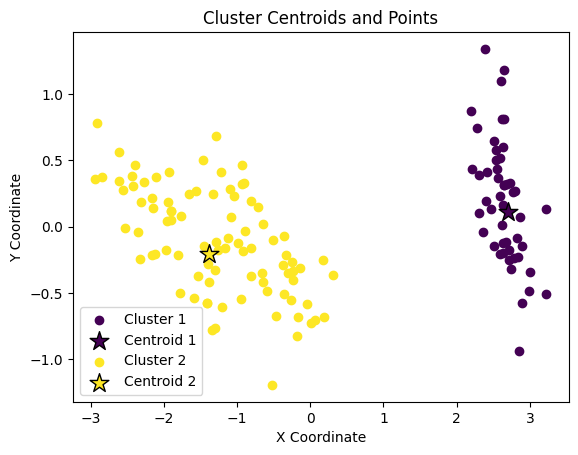

In [660]:
plot_clusters(PCA_Clusters,p_col[1])